# `Laboratorio 6 | Machine Learning`
* Marco Ferraro | B82957
* Roy Padilla | B85854

Descarga del dataset

In [45]:
import torchvision
import torch
import os

CLASSIFIER_LR = 5e-3
CLASSIFIER_THRESHOLD = 0.9
CLASSIFIER_EPOCHS = 400

GEN_LR = 4e-4
NORMALIZER_RESCALE_GRAY = 255
GEN_MOMENTUM = 1e-6
GEN_INPUT_DIM = 350
GEN_EPOCHS = 310
GEN_DECAY = 7e-3

GAN_EPOCH = 50
EPOCH = 100

DATA_PATH = 'Data/'

# Descarga del set de datos
train = torchvision.datasets.MNIST(".", download=True)

# Extracción de datos
x = (train.data.to(torch.uint8)/NORMALIZER_RESCALE_GRAY).float()
y = train.targets

Clase para manejar el dataset

In [46]:
import torch

class Dset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.n_samples = x.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

Pruebas de mostrado de imágenes

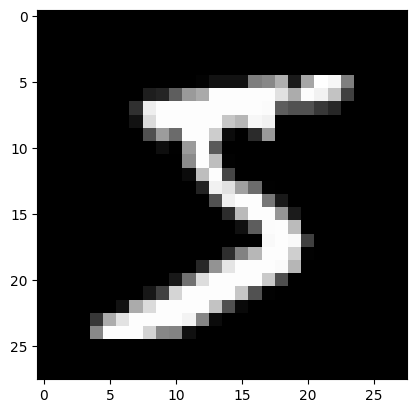

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from torch import flatten

def plot_image(img, save=False, name=None, folder_name=None):
    cmap = 'gray' if img.shape[0]==1 else None
    data = (img.detach()*(255 if img.max()<=1 else 1)).permute((1,2,0)).numpy().astype(np.uint8)
    plt.figure()
    plt.imshow(data,cmap=cmap)
    plt.show()
    if save:
        if not os.path.exists(DATA_PATH + folder_name):
           os.makedirs(DATA_PATH + folder_name)
        if img.shape[0]==1:
            plt.imsave(DATA_PATH + folder_name + '/' + name, data.squeeze(), cmap=cmap)
        else:
            plt.imsave(DATA_PATH + folder_name + '/' + name, data, cmap=cmap)

img_number = 0
img = x[img_number] * NORMALIZER_RESCALE_GRAY
plot_image( img[None, :], True, '{}.png'.format(img_number), folder_name="Test")

Filtrado de las imágenes


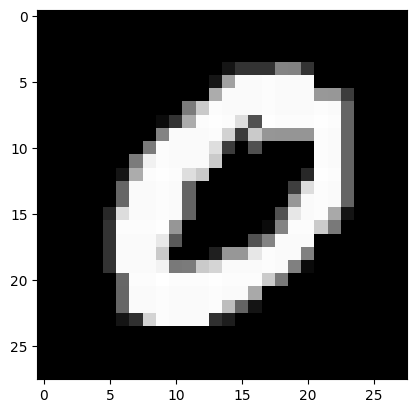

In [48]:
from torch import nonzero

target_number = 0

indeces = y == target_number

x_true = x[nonzero(indeces)]

img_number = 1863
img = x_true[img_number]
plot_image( img, True, '{}.png'.format(img_number), folder_name="Test")


`Clase Classifier`: 
Se va a encarga de determinar si una imagen es o no perteneciente a un dígito en específico o no

In [49]:
from torch import nn, flatten, tensor, cat, device, ones, zeros
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

DEVICE = device("cuda:0")

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Primera convolución
        # Entra una imagen 1x28x28
        self.conv1 =  nn.Conv2d(in_channels = 1, out_channels = 4, kernel_size = (5,5), stride = 1, padding = 'same')
        # Sale una imagen de 4x28x28
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)
        # img de 4x14x14 => 784

        # # Entra una imagen 4x14x14 => 784
        self.conv2 =  nn.Conv2d(in_channels = 4, out_channels = 10, kernel_size = (3,3), stride = 1, padding = 'same')
        # # Sale una imagen de 10x14x14
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2)

        # img de 10x7x7 => 490
        # Red neuronal
        self.fc1 = nn.Linear(490, 800)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(800, 1) # Salida de si es el dígito o no => 1 = Verdadera | 0 = Falso
        self.act2 = nn.Sigmoid()

        # Dropout (opcional)
        self.dropout = nn.Dropout(p = 0.2)
    
    def forward(self, x):
        ''' 
            Sobre-escritura del método de forward propagation, aplicando las capas convolucionales
            y luego las capas densas de la red neuronal
        '''
        # Aplicación de las convoluciones
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = flatten(x, 1)

        # Capas densas
        x = self.act1(self.fc1(x))
        out = self.act2(self.fc2(x))

        return out

    
def train_classifier(opt, model, x_true, x_false, accuracy=None, max_iter=100, batch_size=1000, plot = True):
    '''
        Método de entrenamiento del clasificador donde se toma el conjunto x de imágenes verdades
        y el conjunto de imágenes falsas generadas por el generador para que determine si es o no
        el dígito objetivo.
        Este asume que le llegan los x divididos por 255 => img_i = [0,1]
    '''
    iter_counter = 0
    model_accuracy = 0
    finish_by_accuracy = False
    loss_func = nn.BCELoss() # Binary Cross Entropy

    losses = []
    accuracies = []
    while (iter_counter < max_iter and not(finish_by_accuracy)):
        iter_loss = []
        iter_accuracy = []
        # Generación aleatoria de los índices para utilizar en el entrenamiento
        true_batch = np.random.randint(0, x_true.shape[0], batch_size)
        false_batch = np.random.randint(0, x_false.shape[0], batch_size)

        # Obtención del conjunto de entrenamiento
        # conjunto para predecir 1
        # conjunto para predecir 0
        
        X_train = cat((x_true[true_batch], x_false[false_batch])).to( device=DEVICE)
        y_train = cat((ones(batch_size) , zeros(batch_size))).to( device=DEVICE)

        train_dset = Dset(X_train, y_train)
        train_loader = DataLoader(dataset= train_dset, batch_size = batch_size, shuffle=True)
        # torch.cuda.empty_cache()
        # Entrenamiento
        model = model.to(DEVICE)
        model.train()
        for i, (inputs, labels) in enumerate(train_loader):
            (inputs, labels) = (inputs.to(DEVICE), labels.to(DEVICE))
            y_pred = model( inputs.detach() )
            loss = loss_func(y_pred, labels[:, None])
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            y_pred = y_pred > CLASSIFIER_THRESHOLD
            iter_loss.append(loss.item())

            iter_accuracy.append(accuracy_score(  labels[:, None].cpu() , y_pred.detach().cpu()))
        
        losses.append( np.array(iter_loss).mean())
        model_accuracy = np.array(iter_accuracy).mean()
        accuracies.append(model_accuracy)
        
        finish_by_accuracy = True if accuracy == None else model_accuracy >= accuracy
        iter_counter += 1
    print('Classifier accuracy', accuracies[-1])
    if plot:
        model.eval()
        y_pred = model(train_dset.x) > CLASSIFIER_THRESHOLD

        print(classification_report(train_dset.y.cpu(), y_pred.detach().cpu(), target_names=['Falsa','Real']))
        print('Last loss:', losses[-1])
            
        # Impresión de gráficos y resultados del modelo
        len_ = len(losses)
        xpoints = np.linspace(0, len_, num = len_)
        plt.plot(xpoints, losses)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(("Pérdida del clasificador con {} iteraciones".format(iter_counter) ))
        plt.show()

        len_ = len(accuracies)
        xpoints = np.linspace(0, len_, num = len_)
        plt.plot(xpoints, accuracies)
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title(("Accuracy del clasificador con {} iteraciones".format(iter_counter) ))
        plt.show()   
            

In [50]:
class Generator(nn.Module):
  def __init__(self, input_dim, output_dim=784):
    super(Generator, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
      nn.Linear(input_dim, 512),
      nn.Tanh(),
      nn.Linear(512, 800),
      nn.ReLU(),
      nn.Linear(800, output_dim),
      nn.Sigmoid()
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits


Generator Training

In [51]:
from torch.autograd import Variable

def train_generator(opt, generator: Generator, classifier: Classifier, accuracy=None, max_iter=10000, batch_size=1000, plot = True):

    input_dim = 350
    lr = 2e-4

    iter_counter = 0
    model_accuracy = 0
    finish_by_accuracy = False
    loss_func = nn.BCELoss() # Binary Cross Entropy
    losses = []
    accuracies = []
    y_train = Variable(torch.ones(batch_size, 1).to(DEVICE))
    
    while (iter_counter < max_iter and not(finish_by_accuracy)):
        generator.zero_grad()
        generator.train()
      
        X_train = Variable(torch.randn(batch_size, input_dim).to(DEVICE))
        X_train = X_train.to(torch.uint8)/NORMALIZER_RESCALE_GRAY
        generator_output = generator(X_train)
        generator_output = generator_output.reshape((batch_size, 1, 28, 28))

        
        classifier_output = classifier(generator_output)
        generator_loss = loss_func(classifier_output, y_train)


        generator_loss.backward()
        opt.step()
        losses.append(generator_loss.item())

        classifier_output = classifier_output > CLASSIFIER_THRESHOLD


        accuracies.append(accuracy_score(y_train.cpu() , classifier_output.detach().cpu()))
        model_accuracy = accuracies[-1]
        finish_by_accuracy = True if accuracy == None else model_accuracy >= accuracy
        iter_counter += 1
        
    print('Generator epochs: ', len(accuracies))
    if plot:
        generator.eval()
        generator_output = generator(X_train)
        generator_output = generator_output.reshape((batch_size, 1, 28, 28))
        classifier_output = classifier(generator_output)
        classifier_output = classifier_output > CLASSIFIER_THRESHOLD

        print(classification_report(y_train.cpu(), classifier_output.detach().cpu(), target_names=['Falsa','Real'])) if model_accuracy != 1 else print(end="")
        print('Last loss:', losses[-1])
            
        # Impresión de gráficos y resultados del modelo
        len_ = len(losses)
        xpoints = np.linspace(0, len_, num = len_)
        plt.plot(xpoints, losses)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(("Pérdida del generador con {} iteraciones".format(iter_counter) ))
        plt.show()

        len_ = len(accuracies)
        xpoints = np.linspace(0, len_, num = len_)
        plt.plot(xpoints, accuracies)
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title(("Accuracy del generador con {} iteraciones".format(iter_counter) ))
        plt.show()   


In [52]:
from torch import optim
from torch import tensor

classifier = Classifier().to(DEVICE)
opt_classifier = optim.Adadelta(classifier.parameters(), lr=CLASSIFIER_LR)

gen = Generator(input_dim=GEN_INPUT_DIM).to(DEVICE)
opt_generator = optim.SGD(gen.parameters(), lr=GEN_LR, momentum=GEN_MOMENTUM, weight_decay= GEN_DECAY)


Classifier accuracy 1.0
              precision    recall  f1-score   support

       Falsa       1.00      1.00      1.00      1000
        Real       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Last loss: 0.020001989789307117


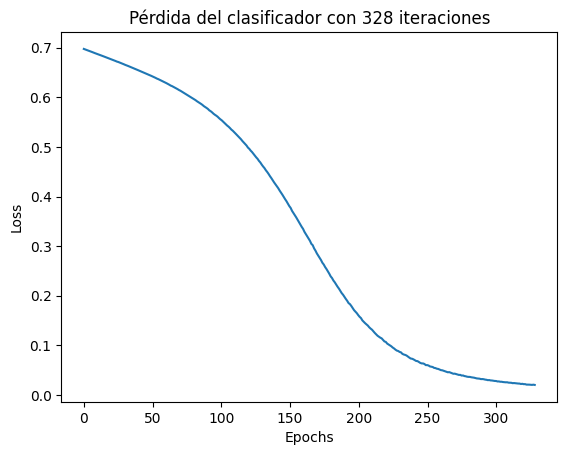

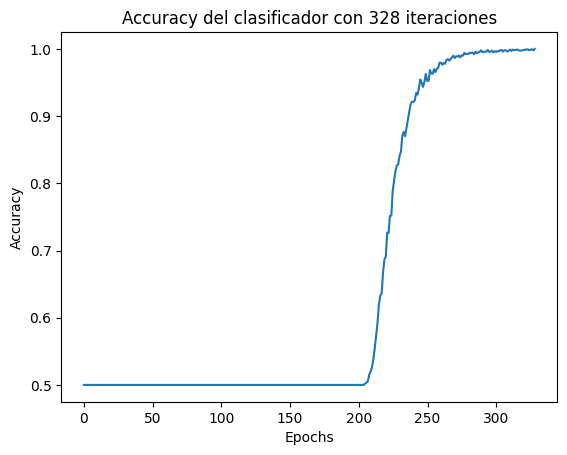

In [53]:
x_false = torch.randn(x_true.shape[0], GEN_INPUT_DIM).to(DEVICE)
x_true = x_true.to(DEVICE)
train_classifier(opt=opt_classifier, model = classifier, x_true = x_true, x_false = gen(x_false).reshape(x_true.shape), accuracy = 1, max_iter= 500)

Generator epochs:  10000
              precision    recall  f1-score   support

       Falsa       0.00      0.00      0.00         0
        Real       1.00      0.01      0.01      1000

    accuracy                           0.01      1000
   macro avg       0.50      0.00      0.01      1000
weighted avg       1.00      0.01      0.01      1000

Last loss: 0.23087918758392334


c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


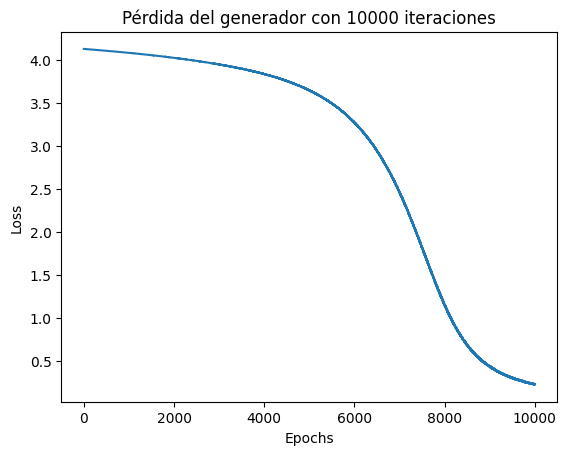

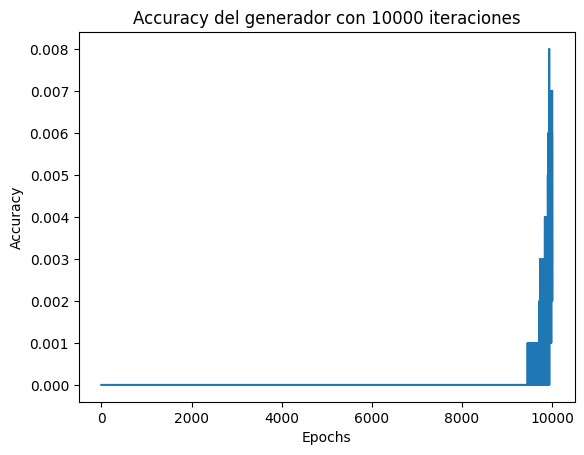

In [54]:
train_generator(opt=opt_generator, generator=gen, classifier=classifier, accuracy=1)

----------------------------------------------------------------------------
GAN Epoch: 0
Generator epochs:  310


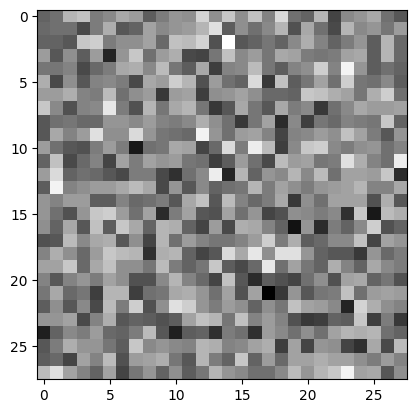

Classifier accuracy 0.833
----------------------------------------------------------------------------
GAN Epoch: 1
Generator epochs:  310


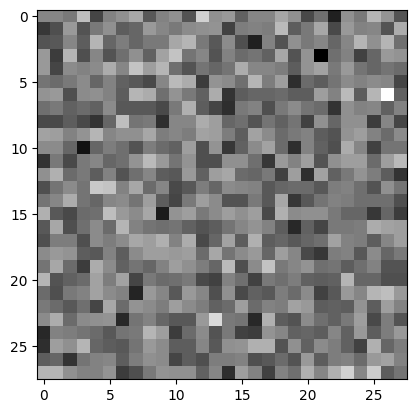

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 2
Generator epochs:  310


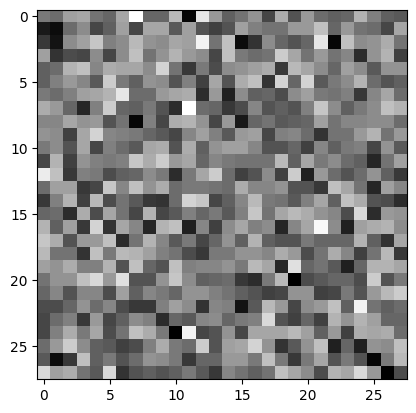

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 3
Generator epochs:  310


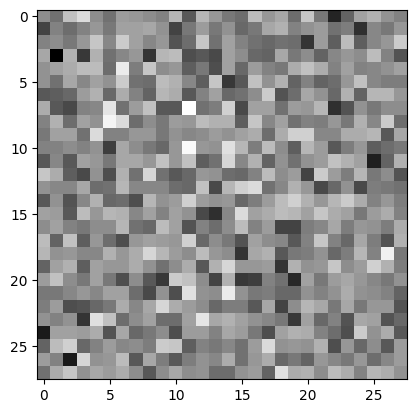

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 4
Generator epochs:  310


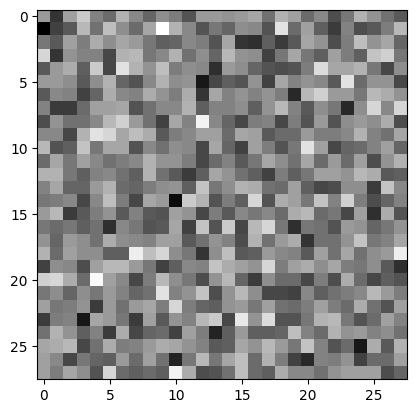

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 5
Generator epochs:  310


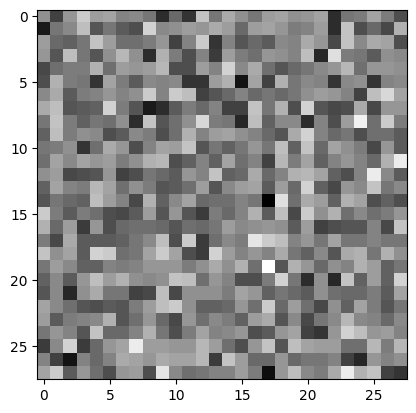

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 6
Generator epochs:  310


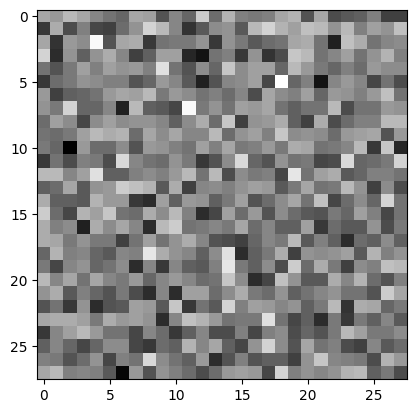

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 7
Generator epochs:  310


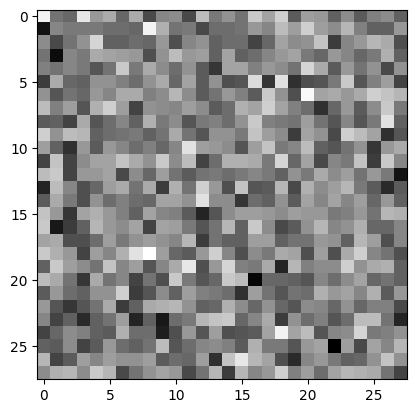

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 8
Generator epochs:  310


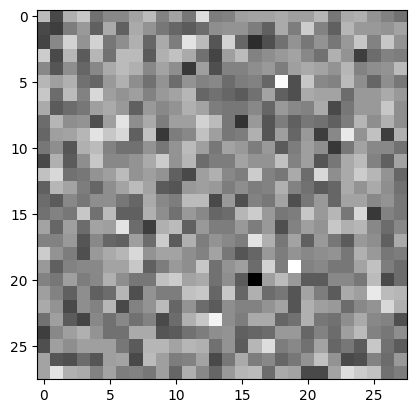

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 9
Generator epochs:  310


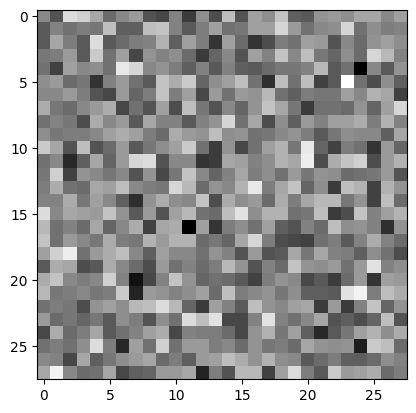

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 10
Generator epochs:  310


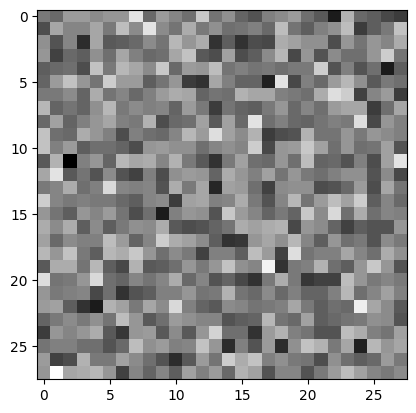

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 11
Generator epochs:  310


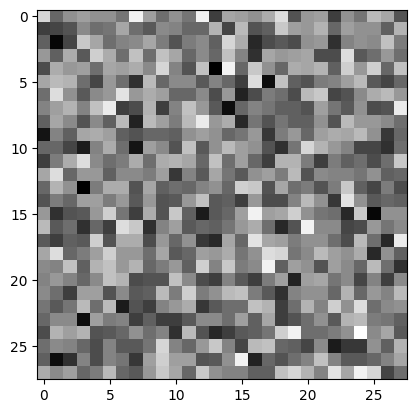

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 12
Generator epochs:  310


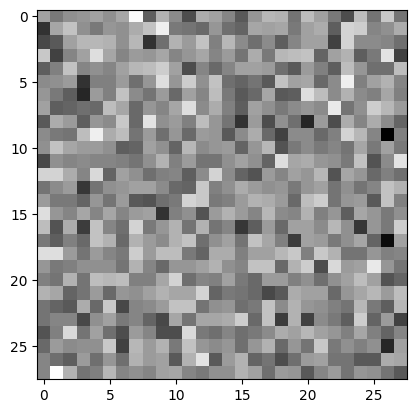

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 13
Generator epochs:  310


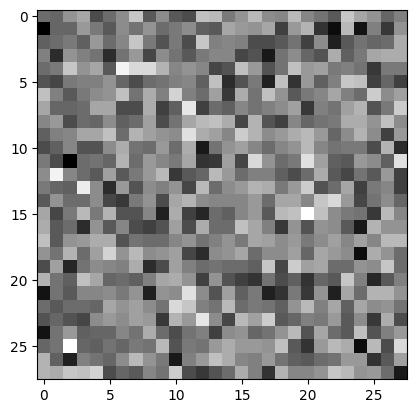

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 14
Generator epochs:  310


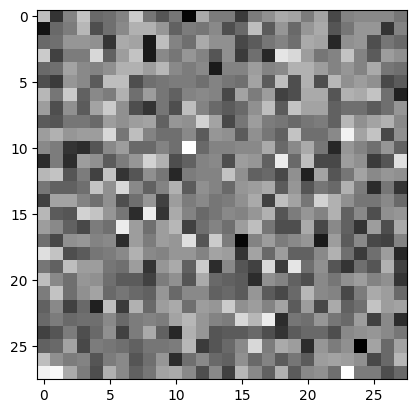

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 15
Generator epochs:  310


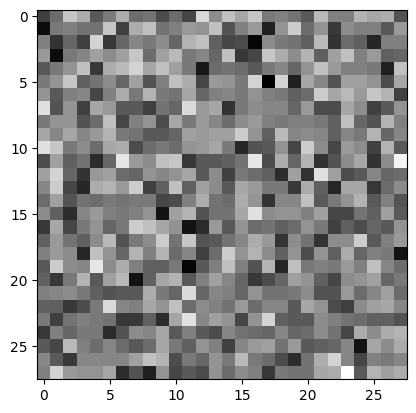

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 16
Generator epochs:  310


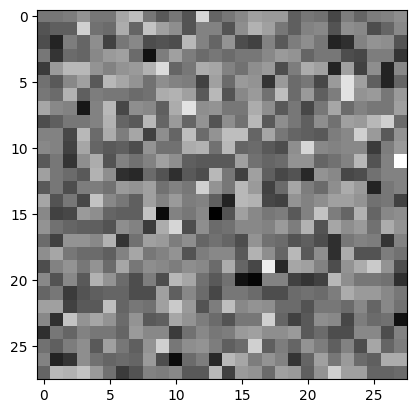

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 17
Generator epochs:  310


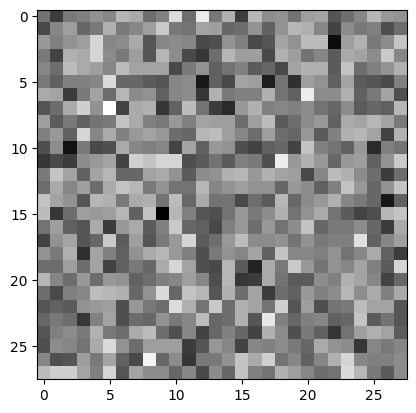

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 18
Generator epochs:  310


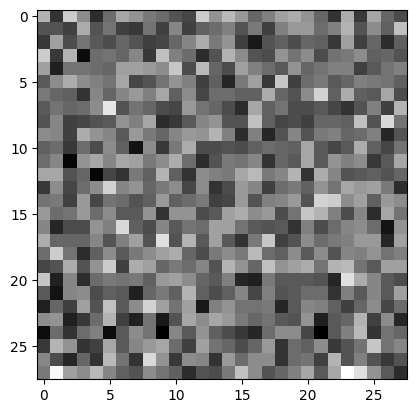

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 19
Generator epochs:  310


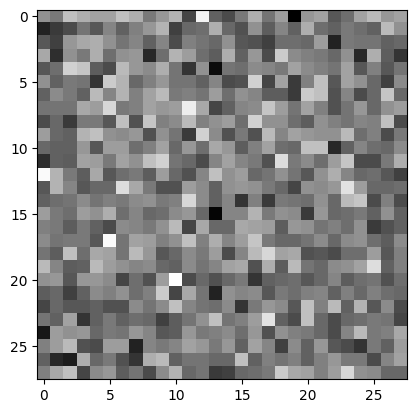

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 20
Generator epochs:  310


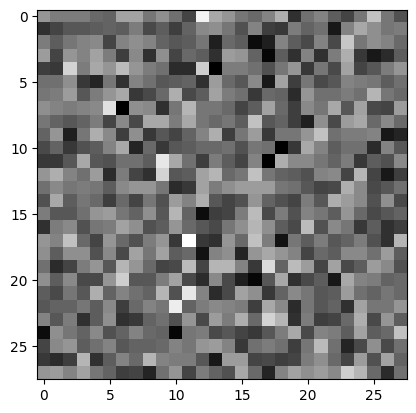

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 21
Generator epochs:  310


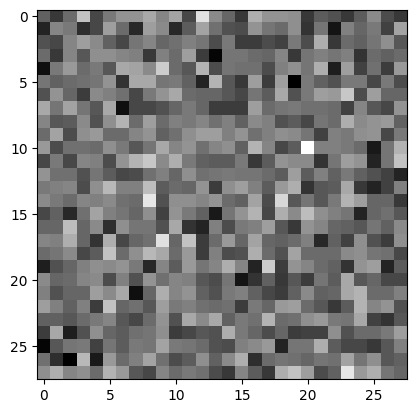

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 22
Generator epochs:  310


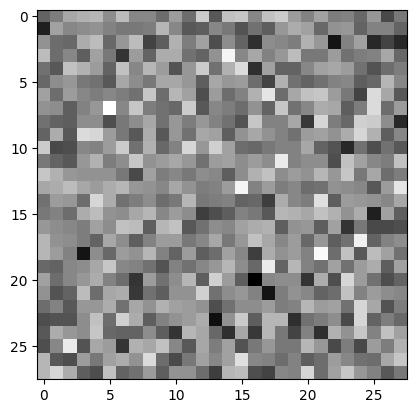

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 23
Generator epochs:  310


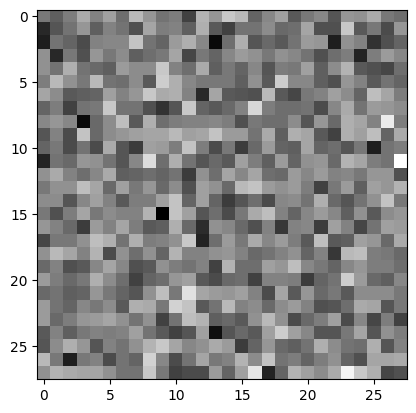

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 24
Generator epochs:  310


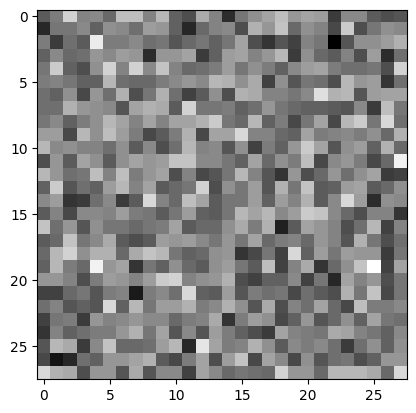

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 25
Generator epochs:  310


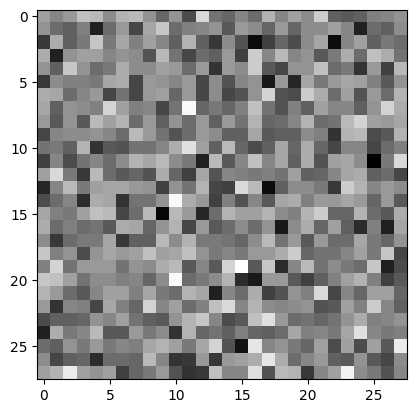

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 26
Generator epochs:  310


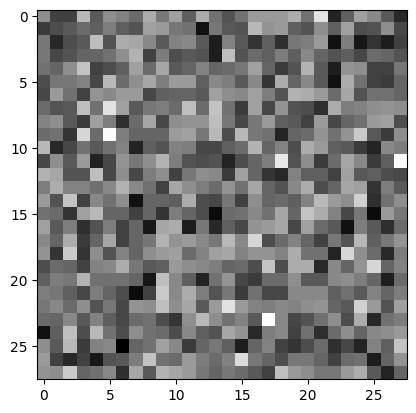

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 27
Generator epochs:  310


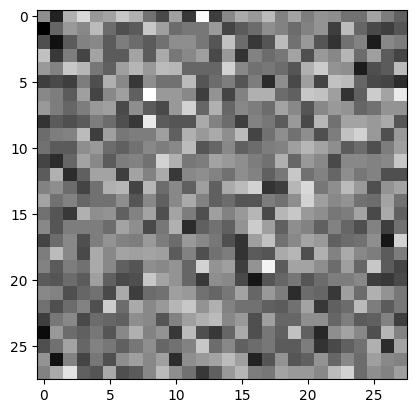

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 28
Generator epochs:  310


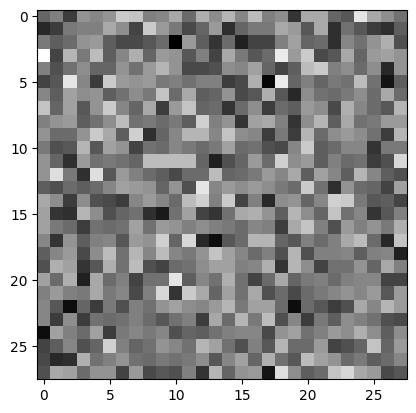

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 29
Generator epochs:  310


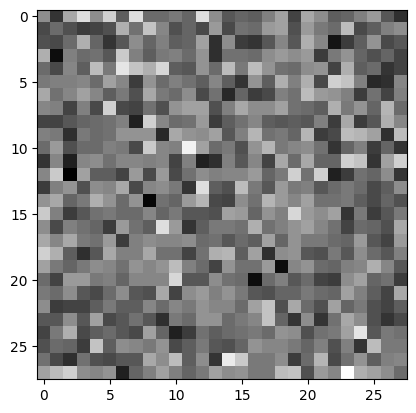

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 30
Generator epochs:  310


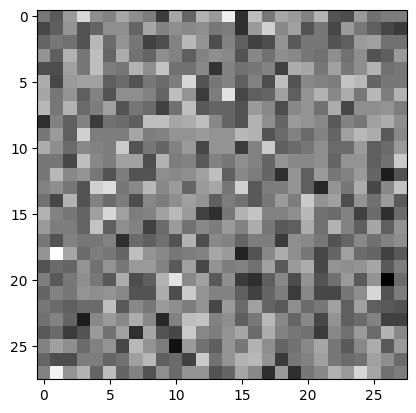

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 31
Generator epochs:  310


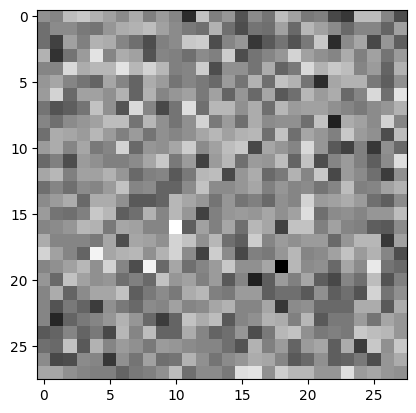

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 32
Generator epochs:  310


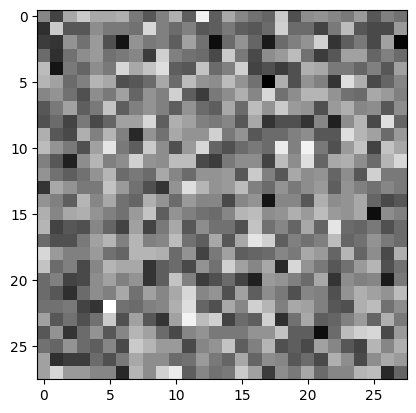

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 33
Generator epochs:  310


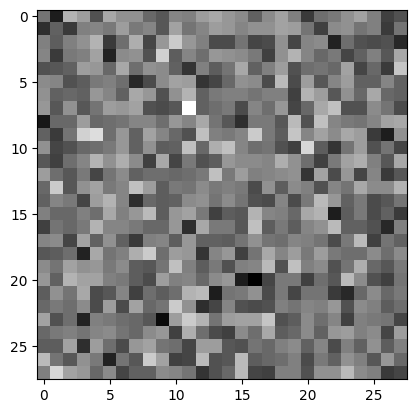

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 34
Generator epochs:  310


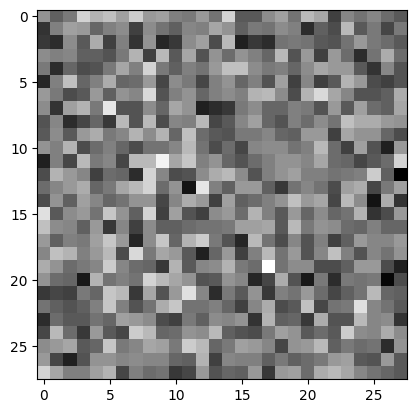

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 35
Generator epochs:  310


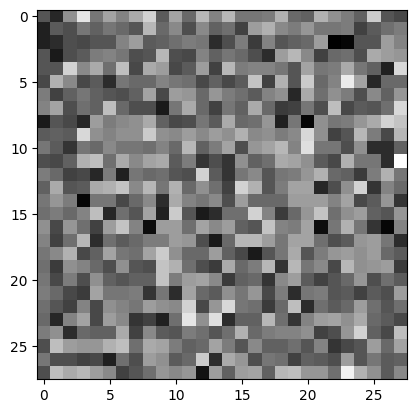

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 36
Generator epochs:  310


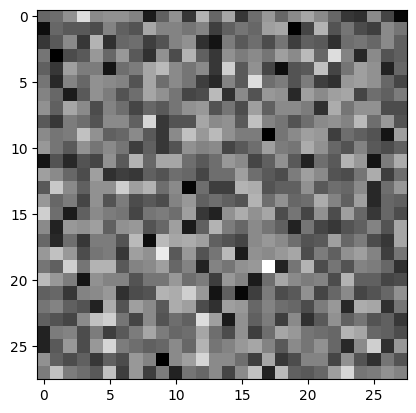

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 37
Generator epochs:  310


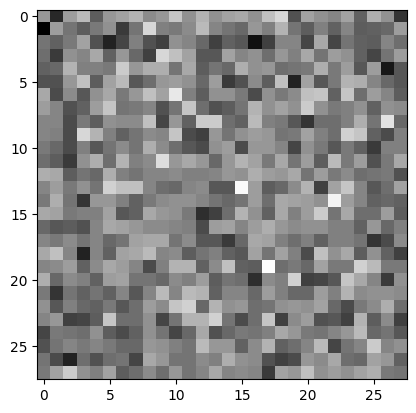

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 38
Generator epochs:  310


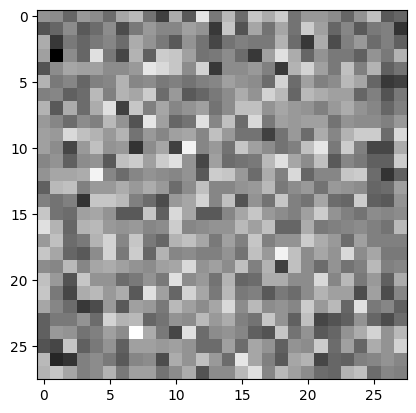

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 39
Generator epochs:  310


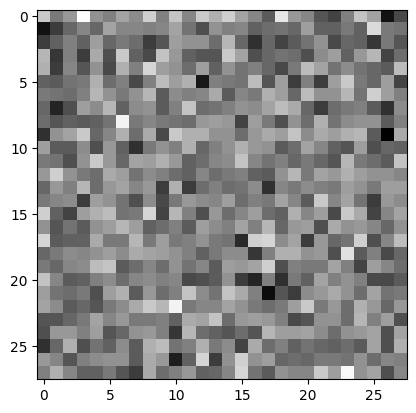

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 40
Generator epochs:  310


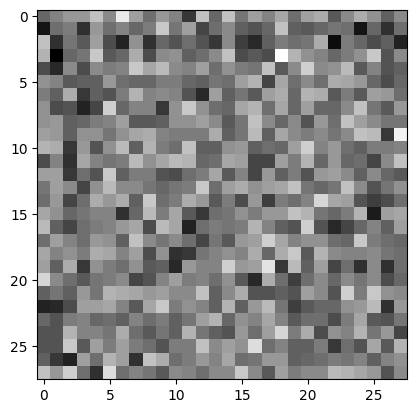

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 41
Generator epochs:  310


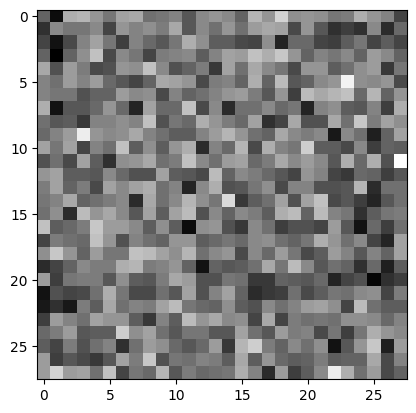

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 42
Generator epochs:  310


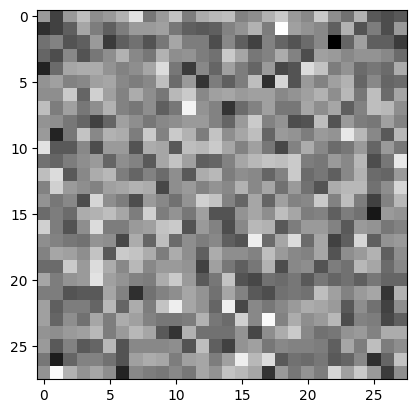

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 43
Generator epochs:  310


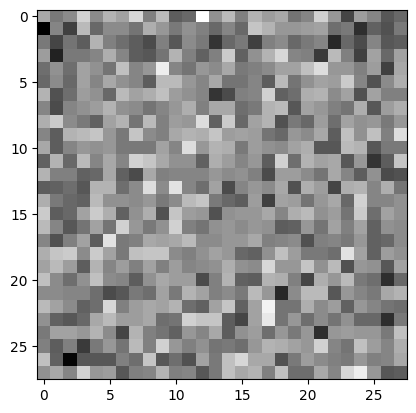

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 44
Generator epochs:  310


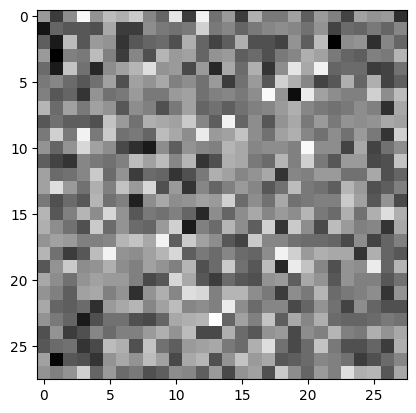

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 45
Generator epochs:  310


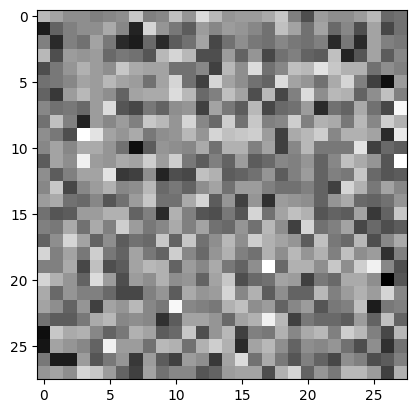

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 46
Generator epochs:  310


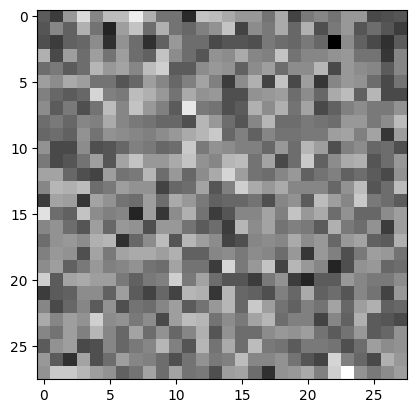

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 47
Generator epochs:  310


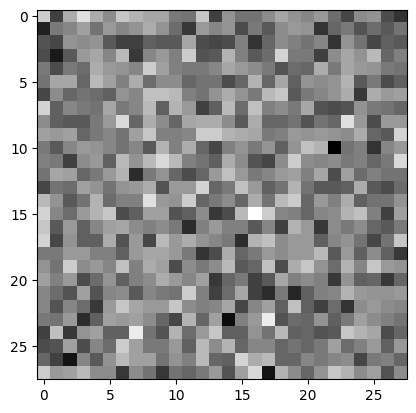

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 48
Generator epochs:  310


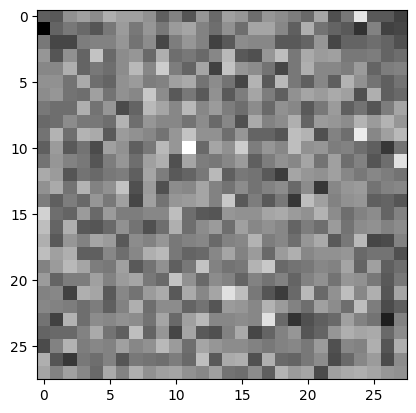

Classifier accuracy 1.0
----------------------------------------------------------------------------
GAN Epoch: 49
Generator epochs:  310


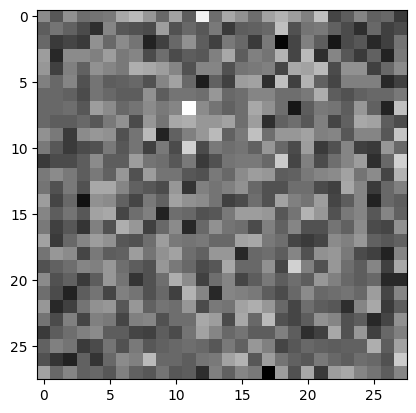

Classifier accuracy 1.0


In [55]:
batch_size = 4000

classifier = Classifier().to(DEVICE)
opt_classifier = optim.Adadelta(classifier.parameters(), lr=CLASSIFIER_LR)

gen = Generator(input_dim=GEN_INPUT_DIM).to(DEVICE)
opt_generator = optim.SGD(gen.parameters(), lr=GEN_LR, momentum=GEN_MOMENTUM, weight_decay=GEN_DECAY)

for e in range(GAN_EPOCH):
  print("----------------------------------------------------------------------------")
  print('GAN Epoch:', e)
  # Toma aleatoria del set real
  true_batch = np.random.randint(0, x_true.shape[0], batch_size)
  x_false_batch = torch.randn(x_true.shape[0], GEN_INPUT_DIM).to(DEVICE)
  # Entrenamos el generador
  train_generator(opt = opt_generator, generator = gen, classifier = classifier, accuracy = 1, plot = False, max_iter= GEN_EPOCHS)
  # Entrenamos el clasificador
  x_false = gen(x_false_batch).reshape((x_false_batch.shape[0], 1, 28, 28))
  img = x_false[np.random.randint(0, x_false.shape[0])]
  plot_image( img.cpu(), True, 'epoch_{}.png'.format(e), folder_name=str(target_number))
  train_classifier(opt=opt_classifier, model=classifier, x_true = x_true[true_batch].to(device=DEVICE), x_false = x_false.detach(), accuracy = 1, max_iter= CLASSIFIER_EPOCHS, plot = False)

¿Qué observa de las imágenes? ¿Se converge al dígito deseado? ¿Qué modificaciones tuvo que realizar a las arquitecturas de sus redes para lograr el resultado deseado? ¿Observa algún comportamiento al exceder cierta cantidad de iteraciones del algoritmo? 
> Vemos que a lo largo de las imagenes, parece que tienden a converger a los digitos deseados, sin embargo, en el proceso de aprendizaje, parece pegar unos "brincos" de retroceso en el proceso de aprendizaje. Esto ocurre en la mayoria de digitos, excepto para el 0, 5 y 7; consideramos que con más épocas se alcanzará a los valores deseados. Una de las modificaciones más importantes que se tuvo que hacer fue dividir entre 255 el tensor de entrada. Esto nos ayudó a mantener los datos entre valores de 0 y 1 y abstraer la representación de la imagen. Al exceder las mil iteraciones vemos que las imagenes no tienden a presentar muchos cambios entre si; podemos asumir que se debe a que no tiende a cambiar los rasgos(pesos) entre las imagenes